## Neural Network Project: Constructing a CNN Auto-Encoder for Traffic Data Imputation

#### 1. Configuring setup

In [ ]:
pip install tensorflow tensorflow-datasets

In [2]:
import numpy as np
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt

import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Dense, UpSampling2D, Conv2DTranspose, BatchNormalization
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error

#### 2. Loading traffic images from directory and preprocessing the data

In [4]:
## Building the training image data sets
training_5 = tf.keras.utils.image_dataset_from_directory('Image_Data/Training/Missing/five', labels = None, color_mode = 'grayscale', 
                                                      batch_size = None, seed = 42, image_size = (200, 200), shuffle = True)
training_15 = tf.keras.utils.image_dataset_from_directory('Image_Data/Training/Missing/fifteen', labels = None, color_mode = 'grayscale', 
                                                      batch_size = None, seed = 42, image_size = (200, 200), shuffle = True)
training_25 = tf.keras.utils.image_dataset_from_directory('Image_Data/Training/Missing/twenty-five', labels = None, color_mode = 'grayscale', 
                                                      batch_size = None, seed = 42, image_size = (200, 200), shuffle = True)
training_target = tf.keras.utils.image_dataset_from_directory('Image_Data/Training/Filled', labels = None, color_mode = 'grayscale', 
                                                      batch_size = None, seed = 42, image_size = (200, 200), shuffle = True)

## Building the testing image data sets
testing_5 = tf.keras.utils.image_dataset_from_directory('Image_Data/Testing/Missing/five', labels = None, color_mode = 'grayscale', 
                                                      batch_size = None, seed = 42, image_size = (200, 200), shuffle = True)
testing_15 = tf.keras.utils.image_dataset_from_directory('Image_Data/Testing/Missing/fifteen', labels = None, color_mode = 'grayscale', 
                                                      batch_size = None, seed = 42, image_size = (200, 200), shuffle = True)
testing_25 = tf.keras.utils.image_dataset_from_directory('Image_Data/Testing/Missing/twenty-five', labels = None, color_mode = 'grayscale', 
                                                      batch_size = None, seed = 42, image_size = (200, 200), shuffle = True)
testing_target = tf.keras.utils.image_dataset_from_directory('Image_Data/Testing/Filled', labels = None, color_mode = 'grayscale', 
                                                      batch_size = None, seed = 42, image_size = (200, 200), shuffle = True)

Found 512 files belonging to 1 classes.
Found 512 files belonging to 1 classes.
Found 512 files belonging to 1 classes.
Found 512 files belonging to 1 classes.
Found 10 files belonging to 1 classes.
Found 10 files belonging to 1 classes.
Found 10 files belonging to 1 classes.
Found 10 files belonging to 1 classes.


In [5]:
## Scaling the data to be between 0 and 1
training_5 = training_5.map(lambda x:(x/255))
training_15 = training_15.map(lambda x:(x/255))
training_25 = training_25.map(lambda x:(x/255))
training_target = training_target.map(lambda x:(x/255))

testing_5 = testing_5.map(lambda x:(x/255))
testing_15 = testing_15.map(lambda x:(x/255))
testing_25 = testing_25.map(lambda x:(x/255))
testing_target = testing_target.map(lambda x:(x/255))

In [7]:
## Converting tf.Dataset objects to numpy arrays
def dataset_to_numpy(ds):
    images = []
    for i, image in enumerate(tfds.as_numpy(ds)): 
        images.append(image)
    return np.array(images)

## Defining the size of the training and validation sets
t_size = int(len(training_target) * 0.75)
v_size = int(len(training_target) * 0.25)

X_train_5 = dataset_to_numpy(training_5)[0:t_size]
X_train_15 = dataset_to_numpy(training_15)[0:t_size]
X_train_25 = dataset_to_numpy(training_25)[0:t_size]
Y_train = dataset_to_numpy(training_target)[0:t_size]

X_val_5 = dataset_to_numpy(training_5)[t_size:(t_size + v_size)]
X_val_15 = dataset_to_numpy(training_15)[t_size:(t_size + v_size)]
X_val_25 = dataset_to_numpy(training_25)[t_size:(t_size + v_size)]
Y_val = dataset_to_numpy(training_target)[t_size:(t_size + v_size)]

X_test_5 = dataset_to_numpy(testing_5)
X_test_15 = dataset_to_numpy(testing_15)
X_test_25 = dataset_to_numpy(testing_25)
Y_test = dataset_to_numpy(testing_target)

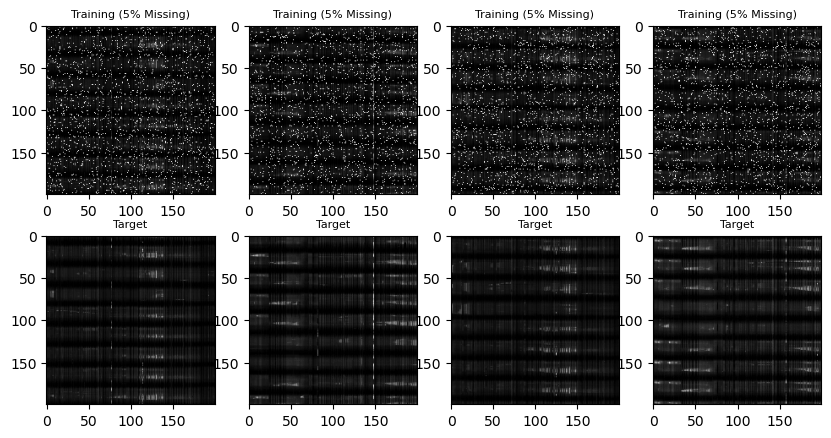

In [8]:
## Visualizing four sample training images 
fig, ax = plt.subplots(nrows = 2, ncols = 4, figsize = (10,5))
for i in range(0, 4):
    ax[0, i].imshow(X_train_5[i], cmap = 'gray'); ax[0, i].set_title('Training (5% Missing)', size = 8)
    ax[1, i].imshow(Y_train[i], cmap = 'gray'); ax[1, i].set_title('Target', fontsize = 8)

#### 3. Constructing the auto-encoder

In [9]:
## Defining the Sequential model
autoencoder = Sequential(name = 'Autoencoder')

## Input Layer
autoencoder.add(Input(shape=(200, 200, 1), name = 'Input'))

## Convo-Pooling Layer 1
autoencoder.add(Conv2D(20, (9,9), 1, data_format = 'channels_last', name = 'Conv_1'))
autoencoder.add(MaxPooling2D(pool_size = (4,4), strides = None, padding = 'valid',  data_format = 'channels_last', name = 'Max_1'))

## Convo-Pooling Layer 2
autoencoder.add(Conv2D(60, (9,9), 1, data_format = 'channels_last', name = 'Conv_2'))
autoencoder.add(MaxPooling2D(pool_size = (2,2), strides = None, padding = 'valid',  data_format = 'channels_last', name = 'Max_2'))

## Convo-Pooling Layer 3
autoencoder.add(Conv2D(180, (9,9), 1, data_format = 'channels_last', name = 'Conv_3'))
autoencoder.add(MaxPooling2D(pool_size = (2,2), strides = None, padding = 'valid',  data_format = 'channels_last', name = 'Max_3'))

## Fully-Connected Layer
autoencoder.add(Dense(18, activation = 'relu', name = 'Dense_1', use_bias = False))
autoencoder.add(Dense(180, activation = 'relu', name = 'Dense_2', use_bias = False))

## Up Convo-Pooling Layer 1
autoencoder.add(UpSampling2D(size = (2,2), data_format = 'channels_last', name = 'Up_Max_1'))
autoencoder.add(Conv2DTranspose(180, (9,9), activation = 'relu', padding = 'valid', data_format = 'channels_last', name = 'Up_Conv_1'))

##Up Convo-Pooling Layer 2
autoencoder.add(UpSampling2D(size = (2,2), data_format = 'channels_last', name = 'Up_Max_2'))
autoencoder.add(Conv2DTranspose(60, (9,9), activation = 'relu', padding = 'valid', data_format = 'channels_last', name = 'Up_Conv_2'))

## Up Convo-Pooling Layer 3
autoencoder.add(UpSampling2D(size = (4,4), data_format = 'channels_last', name = 'Up_Max_3'))
autoencoder.add(Conv2DTranspose(20, (9,9), activation = 'relu', padding = 'valid', data_format = 'channels_last', name = 'Up_Conv_3'))

## Output Layer
autoencoder.add(Conv2D(1, (3, 3), activation = 'relu', padding = 'same',  data_format = 'channels_last', name = 'Output'))

In [10]:
## Compiling the Sequential model
autoencoder.compile(optimizer = 'adam', loss = tf.losses.MeanSquaredError())

## Printing a model summary
autoencoder.summary()

Model: "Autoencoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Conv_1 (Conv2D)             (None, 192, 192, 20)      1640      
                                                                 
 Max_1 (MaxPooling2D)        (None, 48, 48, 20)        0         
                                                                 
 Conv_2 (Conv2D)             (None, 40, 40, 60)        97260     
                                                                 
 Max_2 (MaxPooling2D)        (None, 20, 20, 60)        0         
                                                                 
 Conv_3 (Conv2D)             (None, 12, 12, 180)       874980    
                                                                 
 Max_3 (MaxPooling2D)        (None, 6, 6, 180)         0         
                                                                 
 Dense_1 (Dense)             (None, 6, 6, 18)          

#### 4. a) Fitting the autoencoder model on the data with 5% missing ratio

In [11]:
autoencoder.fit(X_train_5, Y_train, epochs = 10, batch_size = 32, shuffle = True, validation_data = (X_val_5, Y_val))

Epoch 1/10
12/12 [==============================] - 89s 7s/step - loss: 338.6378 - val_loss: 0.0051
Epoch 2/10
12/12 [==============================] - 87s 7s/step - loss: 0.0058 - val_loss: 0.0047
Epoch 3/10
12/12 [==============================] - 88s 7s/step - loss: 0.0044 - val_loss: 0.0040
Epoch 4/10
12/12 [==============================] - 87s 7s/step - loss: 0.0039 - val_loss: 0.0037
Epoch 5/10
12/12 [==============================] - 88s 7s/step - loss: 0.0037 - val_loss: 0.0036
Epoch 6/10
12/12 [==============================] - 87s 7s/step - loss: 0.0037 - val_loss: 0.0036
Epoch 7/10
12/12 [==============================] - 87s 7s/step - loss: 0.0036 - val_loss: 0.0036
Epoch 8/10
12/12 [==============================] - 87s 7s/step - loss: 0.0036 - val_loss: 0.0036
Epoch 9/10
12/12 [==============================] - 88s 7s/step - loss: 0.0036 - val_loss: 0.0035
Epoch 10/10
12/12 [==============================] - 87s 7s/step - loss: 0.0036 - val_loss: 0.0035


#### 4. b) Predicting on the testing data

In [12]:
testing_preds_5 = autoencoder.predict(X_test_5)

1/1 [==============================] - 1s 1s/step


#### 4. c) Visualizing some predictions

In [13]:
## Flattening the data-frames for easier computation
X_test_flat = np.squeeze(X_test_5[1]).flatten()
preds_flat = np.squeeze(testing_preds_5[1]).flatten()

## Recording the indexes where Y_train had a missing value
missing_idx = np.argwhere(X_test_flat == 1.0)

## Filling in the missing values with the imputed pixel value 
X_test_flat[missing_idx] = preds_flat[missing_idx]

## Returning the data-frames back to their original shape
X_test_imputed = X_test_flat.reshape(200, 200)

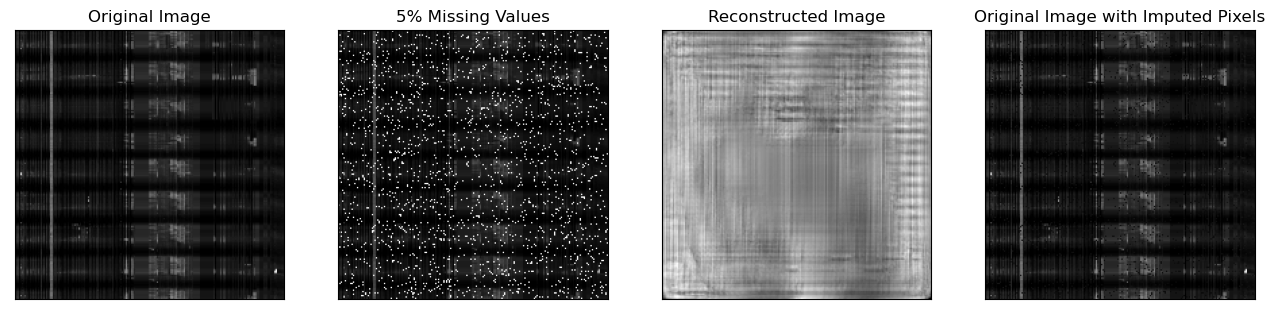

In [15]:
plt.figure(figsize=(16, 7))
ax = plt.subplot(1, 4, 1)
plt.imshow(tf.squeeze(Y_test[1]), cmap = 'gray')
plt.title("Original Image", fontsize = 12)
plt.gray()
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)

ax = plt.subplot(1, 4, 2)
plt.imshow(tf.squeeze(X_test_5[1]), cmap = 'gray')
plt.title("5% Missing Values", fontsize = 12)
plt.gray()
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)

ax = plt.subplot(1, 4, 3)
plt.imshow(tf.squeeze(testing_preds_5[1]), cmap = 'gray')
plt.title("Reconstructed Image", fontsize = 12)
plt.gray()
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)

ax = plt.subplot(1, 4, 4)
plt.imshow(tf.squeeze(X_test_imputed), cmap = 'gray')
plt.title("Original Image with Imputed Pixels", fontsize = 12)
plt.gray()
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)

#### 5. a) Fitting the autoencoder model on the data with 15% missing ratio

In [ ]:
autoencoder.fit(X_train_15, Y_train, epochs = 5, batch_size = 32, shuffle = True, validation_data = (X_val_15, Y_val))

#### 5. b) Predicting on the testing data

In [ ]:
testing_preds_15 = autoencoder.predict(X_test_15)

#### 5. c) Visualizing some predictions

In [ ]:
## Flattening the data-frames for easier computation
X_test_flat = np.squeeze(X_test_15[5]).flatten()
preds_flat = np.squeeze(testing_preds_15[5]).flatten()

## Recording the indexes where Y_train had a missing value
missing_idx = np.argwhere(X_test_flat == 1.0)

## Filling in the missing values with the imputed pixel value 
X_test_flat[missing_idx] = preds_flat[missing_idx]

## Returning the data-frames back to their original shape
X_test_imputed = X_test_flat.reshape(200, 200)

In [ ]:
plt.figure(figsize=(16, 7))
ax = plt.subplot(1, 4, 1)
plt.imshow(tf.squeeze(Y_test[5]), cmap = 'gray')
plt.title("Original Image", fontsize = 12)
plt.gray()
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)

ax = plt.subplot(1, 4, 2)
plt.imshow(tf.squeeze(X_test_15[5]), cmap = 'gray')
plt.title("15% Missing Values", fontsize = 12)
plt.gray()
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)

ax = plt.subplot(1, 4, 3)
plt.imshow(tf.squeeze(testing_preds_15[5]), cmap = 'gray')
plt.title("Reconstructed Image", fontsize = 12)
plt.gray()
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)

ax = plt.subplot(1, 4, 4)
plt.imshow(tf.squeeze(X_test_imputed), cmap = 'gray')
plt.title("Original Image with Imputed Pixels", fontsize = 12)
plt.gray()
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)

#### 6. a) Fitting the autoencoder model on the data with 25% missing ratio

In [ ]:
autoencoder.fit(X_train_25, Y_train, epochs = 5, batch_size = 32, shuffle = True, validation_data = (X_val_25, Y_val))

#### 6. b) Predicting on the testing data

In [ ]:
testing_preds_25 = autoencoder.predict(X_test_25)

#### 6. c) Visualizing some predictions

In [ ]:
## Flattening the data-frames for easier computation
X_test_flat = np.squeeze(X_test_25[8]).flatten()
preds_flat = np.squeeze(testing_preds_25[8]).flatten()

## Recording the indexes where Y_train had a missing value
missing_idx = np.argwhere(X_test_flat == 1.0)

## Filling in the missing values with the imputed pixel value 
X_test_flat[missing_idx] = preds_flat[missing_idx]

## Returning the data-frames back to their original shape
X_test_imputed = X_test_flat.reshape(200, 200)

In [ ]:
plt.figure(figsize=(16, 7))
ax = plt.subplot(1, 4, 1)
plt.imshow(tf.squeeze(Y_test[8]), cmap = 'gray')
plt.title("Original Image", fontsize = 12)
plt.gray()
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)

ax = plt.subplot(1, 4, 2)
plt.imshow(tf.squeeze(X_test_25[8]), cmap = 'gray')
plt.title("25% Missing Values", fontsize = 12)
plt.gray()
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)

ax = plt.subplot(1, 4, 3)
plt.imshow(tf.squeeze(testing_preds_25[8]), cmap = 'gray')
plt.title("Reconstructed Image", fontsize = 12)
plt.gray()
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)

ax = plt.subplot(1, 4, 4)
plt.imshow(tf.squeeze(X_test_imputed), cmap = 'gray')
plt.title("Original Image with Imputed Pixels", fontsize = 12)
plt.gray()
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)

#### 7. Evaluating the accuracy of imputed values

In [24]:
def imputed_mse(Y_true, Y_pred):
    return mean_squared_error(Y_true, Y_pred, squared = False)

def imputed_mae(Y_true, Y_pred):
    return mean_absolute_error(Y_true, Y_pred)

def evaluation(X, Y, preds):
    mse = list(); mae = list()
    
    for i in range(len(preds)):
        
        ## Flattening the arrays 
        X_flat = np.squeeze(X[i]).flatten()
        Y_flat = np.squeeze(Y[i]).flatten()
        preds_flat = np.squeeze(preds[i]).flatten()
        
        ## Finding the index of imputed values
        missing_idx = np.argwhere(X_flat == 1.0)
        
        ## Extracting the Y_true and Y_pred values
        Y_true = Y_flat[missing_idx]
        Y_pred = preds_flat[missing_idx]
        
        ## Computing the metrics:
        mse.append(imputed_mse(Y_true, Y_pred))
        mae.append(imputed_mae(Y_true, Y_pred))
        
    return mse, mae

In [29]:
mse_5, mae_5 = evaluation(X_test_5, Y_test, testing_preds_5)
print(f'MSE: {np.mean(mse_5)}   MAE: {np.mean(mae_5)}')

MSE: 0.05668581277132034   MAE: 0.040894217789173126
